In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from nltk.corpus import words
from sklearn.cross_validation import cross_val_score


%matplotlib inline
sent_tokenizer=nltk.data.load('tokenizers/punkt/english.pickle')

##Read Data

In [29]:
#Read the csv file
df = pd.read_csv("yelp_data_official_training.csv", low_memory=False, delimiter='|')
df.head()

,ID,Category,Review Text
0,0,2,Don't waste your time. We had two different p...
1,1,2,I will start by saying we have a nice new deck...
2,2,2,When I wanted a deck for the back of my home I...
3,3,5,Our cat went out the other night and must have...
4,4,5,Greentree Animal clinic is the absolute best! ...


####Shuffle and reset index

In [30]:
#Take out NaN
filtered_data = df["Review Text"].notnull()
df_filtered = df[filtered_data]

#Shuffle the data
random_index = np.random.permutation(df_filtered.index)
df_shuffled = df.ix[random_index, ['Category', 'Review Text']]
df_shuffled.reset_index(drop=True, inplace=True)
df_shuffled[:5]

,Category,Review Text
0,2,If you have never been charged for cleaning an...
1,2,Bought a reconditioned Husqvarna at Lowe's. T...
2,3,I love it when I make a referral and have peop...
3,2,I was pleasantly surprised by Lamps Plus. We ...
4,1,I came to this salon after previously scared o...


we shuffle the rows and create train and dev sets 

In [31]:
#Split the data into train and dev
rows, columns = df_shuffled.shape
train_size = round(rows*.7)
dev_size   = round(rows*.3)


df_train = df_shuffled.loc[:train_size]
df_dev = df_shuffled.loc[train_size:dev_size+train_size].reset_index(drop=True)

df_test = pd.read_csv("yelp_data_official_test_nocategories.csv", low_memory=False, delimiter='|')
df_test.head()

,ID,Review Text
0,0,We had the same doctor in Houston for over 12 ...
1,1,My mother passed away recently at the age of 9...
2,2,"Updating! So, the dispute was resolved at this..."
3,3,We just moved here from WA and are looking for...
4,4,They have lost the best of the best. The last ...


##Count Vectorizer

In [41]:
#building a vector tokenizer
vec = CountVectorizer(stop_words='english', min_df=5, max_df=0.2)  

arr_train_feature_sparse = vec.fit_transform(df_train['Review Text'])
arr_train_feature = arr_train_feature_sparse.toarray()
print("the size of the vector the training set is as follows: {}".format(arr_train_feature.shape))

arr_dev_feature_sparse = vec.transform(df_dev["Review Text"])
arr_dev_feature = arr_dev_feature_sparse.toarray()
print("the size of the vector the development set is as follows: {}".format(arr_dev_feature.shape))

arr_test_feature_sparse = vec.transform(df_test['Review Text'])
arr_test_feature = arr_test_feature_sparse.toarray()

the size of the vector the training set is as follows: (33600, 14033)
the size of the vector the development set is as follows: (14400, 14033)


####Let's visualize our bag of words

//anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


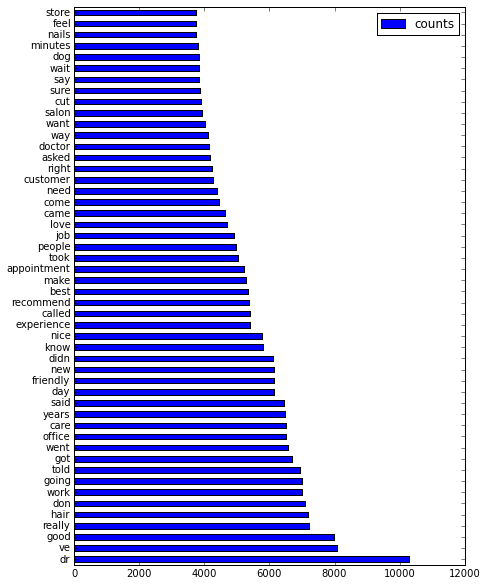

In [42]:
feature_sum = arr_train_feature.sum(axis=0)   #sum the counts of each feature
df_feature_sum = pd.DataFrame({'counts': feature_sum})
df_feature_sum.index = vec.get_feature_names()
df_feature_sum.sort('counts', ascending=False)[:50].plot(kind='barh', figsize=(7,10));

In [45]:
nb = MultinomialNB(alpha=1.0)
nb_model = nb.fit(arr_train_feature, df_train.Category)
nb_predictions = nb_model.predict(arr_dev_feature)
accuracy_score(df_dev.Category, nb_predictions)
# nb1 = MultinomialNB(alpha=1.0)
# cross_val_score(nb1,arr_train_feature, df_train.Category, cv = 5)

0.89847222222222223

In [46]:
nb_test_predictions = nb_model.predict(arr_test_feature)
final_test_predictions = pd.DataFrame( {'Category': nb_test_predictions})
final_test_predictions.to_csv('yelp_data_official_test_submission_v1.csv', header=True, index=True)

##Pipeline and GridSearchCV

In [36]:
multi_pipeline = MultinomialNB()
pipeline_vec = CountVectorizer(stop_words='english')  
steps = [('feature_selection', pipeline_vec),
        ('multi_pipe', multi_pipeline)]

pipeline = Pipeline(steps)

In [37]:
#Do GridSearch
from sklearn import grid_search
parameters = { 'feature_selection__min_df': [3, 4, 5, 6, 7],
              'multi_pipe__alpha':[ 0.9, 1.0, 1.1],
             'feature_selection__max_df': [.1, .2, .3, .4]}

clf = grid_search.GridSearchCV(pipeline,  param_grid=parameters, cv = 5)
clf.fit(df_train['Review Text'], df_train.Category)   


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('feature_selection', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None...one, vocabulary=None)), ('multi_pipe', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'feature_selection__min_df': [3, 4, 5, 6, 7], 'feature_selection__max_df': [0.1, 0.2, 0.3, 0.4], 'multi_pipe__alpha': [0.9, 1.0, 1.1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [38]:
##Predict on dev test
nb_pipe_dev_predictions = clf.predict(df_dev["Review Text"])
accuracy_score(df_dev.Category, nb_pipe_dev_predictions)

0.89909722222222221

In [39]:
##Predict on test set
nb_pipe_test_predictions = clf.predict(df_test['Review Text'])
pipe_final_test_predictions = pd.DataFrame({'Category': nb_pipe_test_predictions})
pipe_final_test_predictions.to_csv('yelp_data_official_test_submission_pipeline.csv', header=True, index=True)
pipe_final_test_predictions.head()

,Category
0,3
1,3
2,3
3,3
4,3


In [40]:
pipe_final_test_predictions.head(30)

,Category
0,3
1,3
2,3
3,3
4,3
5,3
6,3
7,3
8,3
9,3
